In [1]:
import time as t
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.visualization import *
import qiskit_machine_learning as qml
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import EfficientSU2
import qiskit.circuit as Q

import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    CrossEntropyLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [4]:
epochs = 10  # Set number of epochs
# filt = [0,1,3,4,8]
filt = None

if filt==None: filt = [i for i in range(0,10)]

qubits = len(filt)
n_train = 200*len(filt)
n_test = int(n_train/10);

print(
f'using {qubits} Qubits @{n_train} datapoints: {filt} for {epochs} epochs'
)

using 10 Qubits @2000 datapoints: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] for 10 epochs


In [5]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.array([], dtype=int)
for label in filt:
    idx = np.append(idx, np.where(X_train.targets == label)[0][:n_train])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)


X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))
idx = np.array([], dtype=int)
for label in filt:
    idx = np.append(idx, np.where(X_test.targets == label)[0][:n_test])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [6]:
def ansat(prefix):
    ansatz = EfficientSU2(2, su2_gates=['rz'], entanglement='linear', reps=1, parameter_prefix=prefix)
    return ansatz
qubits = 4
shots = 512

backend = qiskit.Aer.get_backend('aer_simulator')

ParameterView([ParameterVectorElement(a[0]), ParameterVectorElement(a[1]), ParameterVectorElement(a[2]), ParameterVectorElement(a[3]), ParameterVectorElement(b[0]), ParameterVectorElement(b[1]), ParameterVectorElement(b[2]), ParameterVectorElement(b[3]), ParameterVectorElement(c[0]), ParameterVectorElement(c[1]), ParameterVectorElement(c[2]), ParameterVectorElement(c[3]), Parameter(rx_0), Parameter(rx_1), Parameter(rx_2)])
[0.10859611 0.01306086 0.70109175 0.02669421 0.40767664 0.6672167
 0.7279266  0.056342   0.37725109 0.04010393 0.8114307  0.71991142
 0.84354993 0.79071367 0.92544702]
PROB of 1: 0.490234375


/opt/homebrew/Caskroom/miniconda/base/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniconda/base/envs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


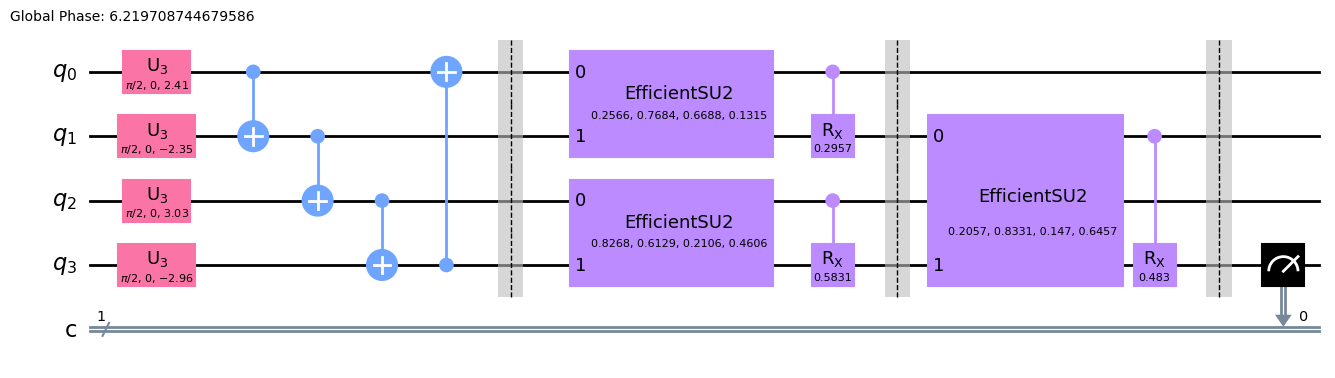

In [7]:
def Conv2x2(inputs):
    params = [Q.Parameter(f"rx_{i}") for i in range(0,3)]
    all_q = [i for i in range(qubits)]

    qc = Q.QuantumCircuit(qubits, 1)
    
    qc.h(all_q)
    for i in all_q:
        qc.rx(inputs[i], i);
    for i in all_q:
        qc.cx(i,(i+1)%4)

    qc.barrier()
    qc.compose(ansat('a'),qubits=[0,1], inplace=True)
    qc.compose(ansat('b'),qubits=[2,3], inplace=True)
    qc.crx(params[0], 0,1)
    qc.crx(params[1], 2,3)
    qc.barrier()

    qc.compose(ansat('c'),qubits=[1,3], inplace=True)    
    qc.crx(params[2], 1, 3)
    qc.barrier()

    qc.measure(3,0)
    
    print(qc.parameters)
    return qiskit.compiler.transpile(qc, optimization_level=3)

inputs = np.random.randn(4).astype(np.float16)
circ = Conv2x2(inputs)

weights = np.random.rand(len(circ.parameters))
print(weights)

bound = circ.assign_parameters({param: np.round(np.random.rand(),4) for param in circ.parameters})

result = qiskit.execute(circ, backend, shots=shots).result().get_counts()
one = result['1']/shots
print(f"PROB of 1: {one}")
bound.draw("mpl")

In [13]:
class QuantumCircuit():
    def __init__(self, qubits):
        self.qubits = qubits
        self.params = [Q.Parameter(f"rx_{i}") for i in range(0,qubits)]
        self.all_q = [i for i in range(qubits)]
        self.qc = Q.QuantumCircuit(qubits, 1)

        self.qc.h(self.all_q)
        for i in self.all_q:
            self.qc.rx(self.params[i], i)
        for i in self.all_q:
            self.qc.cx(i, (i+1)%4)

        self.qc.barrier()
        self.qc.compose(ansat('a'), qubits=[0,1], inplace=True)
        self.qc.compose(ansat('b'), qubits=[2,3], inplace=True)
        self.qc.crx(self.params[0], 0,1)
        self.qc.crx(self.params[1], 2,3)
        self.qc.barrier()

        self.qc.compose(ansat('c'), qubits=[1,3], inplace=True)    
        self.qc.crx(self.params[2], 1,3)
        self.qc.barrier()

        self.qc.measure(3,0)

        self.qc = qiskit.compiler.transpile(self.qc, optimization_level=3)

    def __call__(self, x):
        shots = 512
        results = []
        for sample in x:
            print(sample.shape)
#             circ = self.qc.bind_parameters(dict(zip(self.params, sample)))
#             job = qiskit.execute(circ, backend, shots=shots)
#             results.append(job.result().get_counts())
        return results

In [14]:
class QuantumConv2x2(Module):
    def __init__(self, qubits):
        super().__init__()
        self.qubits = qubits

    def forward(self, x):
        qc = QuantumCircuit(self.qubits)
        x = qc(x)
        x = torch.stack([torch.tensor(result['1']/shots) for result in x])
        return x

In [15]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = QuantumConv2x2(4)
        self.conv2 = QuantumConv2x2(4)
        self.conv3 = QuantumConv2x2(4)
        self.conv4 = QuantumConv2x2(4)
        self.fc = Linear(4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 4)
        x = self.fc(x)
        return x

model = Net()
print(model)
print(model(torch.randn(2, 1, 28, 28)))

Net(
  (conv1): QuantumConv2x2()
  (conv2): QuantumConv2x2()
  (conv3): QuantumConv2x2()
  (conv4): QuantumConv2x2()
  (fc): Linear(in_features=4, out_features=10, bias=True)
)
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


RuntimeError: stack expects a non-empty TensorList

In [ ]:
# Define model, optimizer, and loss function
optimizer = Adam(model4.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.99)

loss_func = CrossEntropyLoss()

# Start training
loss_list = [2.3]  # Store loss history
model4.train()  # Set model to training mode

itrs = len(train_loader)
logspan = int(itrs*44/100) # 12%

print(f"Running training for {qubits} Qubits @{itrs} itrs/epoch")

In [ ]:
for epoch in range(epochs):
    total_loss = []
    times = []
    now = t.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        z = t.time()
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
        z = t.time() - z;
        if ((batch_idx%(logspan))==0): print(f"{int(z)*logspan} sec/{logspan}itrs")
    
    scheduler.step()
    end = int((t.time() - now)/60)+1
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Trained [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]), 
          f"in {end} min \t(<{int((epochs-epoch-1)*end)} min left)")
    
    diff = np.abs(loss_list[-1] - loss_list[-2]) /loss_list[-1]; 
    if diff <= 0.0005: # Early stopping criterial loss diff = 0.1%
        print("Τraining Complete")
        break;

In [ ]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [ ]:
model4.eval()
with torch.no_grad():
    
    correct = 0
    for (data, target) in test_loader:
        output = model4(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
                sum(total_loss) / len(total_loss),
                correct / len(test_loader) * 100)
            )
    print(f"\tRandom: {int(100/len(filt))}%")

In [ ]:
# Plot predicted labels

n_samples_show = 15
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model4.eval()
with no_grad():
    for (data, target) in test_loader:
        if count == n_samples_show:
            break
        output = model4(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="viridis")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("{}".format(pred.item()))

        count += 1

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
html{filter:invert(0.86)}

div.prompt{opacity: 0.5;}

.btn-default{border-color: transparent;}

#header-container{display:none !important;}

div.cell.selected, div.cell.selected.jupyter-soft-selected{border-color: transparent;}
</style>
""")

In [2]:
from IPython.core.display import HTML
HTML("""
<div style="display:flex;justify-content:space-around;">
<a href="./BenchMark1.ipynb">BM1: [01]x1100</a>
<a href="./NonBench2.ipynb">NB2: [01348]x1k</a>
</div>
""")